# Gharsa's Eye walkthrough


>[Gharsa's Eye walkthrough](#scrollTo=-5BPhcVCtw5B)

>[Set-up](#scrollTo=0124ZhVijiqZ)

>[Helper functions](#scrollTo=chdVA3-tdMUK)

>[Automatic Mask Generation](#scrollTo=UGX_6Sm_6ZUJ)

>>>[Instantiate the SAM model](#scrollTo=I7IxQYD2p2G6)

>>>[Prepare test images](#scrollTo=3upCsL2e5Pc5)

>>[Generate masks](#scrollTo=MiYeKvPLhM-h)

>>[Let's visualize the automatically generated masks](#scrollTo=I5NEw_RRvaPe)

>>[We can do better](#scrollTo=ZWpSnwR5cV34)

>[Full pipeline](#scrollTo=Qbyy9fAYtV7F)

>[More examples](#scrollTo=Uxtcy9BNtduw)

>[Resources](#scrollTo=agNOmObztmKq)



We start with installing all required libraries

In [19]:
# First is the SAM library and all of its dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

# # We also install supervision for visualizing the SAM's results
# !pip install -q supervision==0.23.0

# To view SAM masks
!pip install opencv-python matplotlib

# Get a checkpoint of SAM
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done
--2025-07-12 20:07:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   155MB/s    in 22s     

2025-07-12 20:08:21 (110 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



# Set-up

In [20]:
import torch
import torchvision
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [21]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True


# Helper functions

###1.
show_anns' [credits](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)

In [22]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)

### 2.
Here is pipeline I created to highlight the possibly diseased areas in the leaf. You can learn how to make one from my blog found here.

In [23]:
def color_mask(img_path):
    img = cv2.imread(img_path) # Read the image

    # Convert the color standard to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Find the leaf
    leaf_mask = cv2.inRange(hsv, (25, 100, 70), (65, 255, 255))

    # Create a black 1-channel image to draw on the leaf mask
    leaf = np.zeros(leaf_mask.shape, dtype=np.uint8)

    # Get the outermost contour
    contours, _ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the black image
    cv2.drawContours(leaf, contours, -1, 255, cv2.FILLED)

    # Construct the powdery mildew mask
    mildew_mask = cv2.inRange(hsv, (0, 0, 180), (180,  60, 255))

    # Construct the spots mask
    spot_mask = cv2.inRange(hsv, (10,100,10), (20, 255, 200))

    # Construct the rot mask
    rot_mask1 = cv2.inRange(hsv, (5,10,20), (60,120,100))
    rot_mask2 = cv2.inRange(hsv, (10,100,10), (20, 255, 200))
    rot_mask = cv2.bitwise_or(rot_mask1, rot_mask2)

    # Combine the mildew, spot and rot masks then confine within the leaf - others can appear on edges
    temp_mask = cv2.bitwise_or(mildew_mask, spot_mask)
    temp_mask = cv2.bitwise_or(temp_mask, rot_mask)
    temp_mask = cv2.bitwise_and(leaf, leaf, mask=temp_mask)

    # Construct the burn mask
    burn_mask = cv2.inRange(hsv, (10,100,10), (20, 255, 200))

    # Construct the chlorosis mask
    chlorosis_mask = cv2.inRange(hsv, (20, 150, 150), (37, 255, 255))

    # Combine disease masks
    disease_mask = cv2.bitwise_or(temp_mask, burn_mask)
    disease_mask = cv2.bitwise_or(disease_mask, chlorosis_mask)

    # Smooth out edges and close gaps in mask
    kh, kw = [max(9, int(round(min(img.shape[:2]) * 0.01))) | 1]*2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kh, kw))
    disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_CLOSE, kernel)
    disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_OPEN,  kernel)


    return disease_mask

### 3.
Function responsible for cropping segments with a minimum size and retaining information.

In [24]:
MIN_SIZE = 256          # smallest crop side you allow

def _cluster_bboxes(bboxes, min_size):
    """
    Greedy one-pass clustering:
        – Start a new cluster for each bbox that cannot fit into an existing one.
        – A bbox fits an existing cluster if the *union* of the two
          is ≤ min_size in both width and height.
    Returns: list of dicts  { "bounds": (x1,y1,x2,y2), "indices": [i,…] }
    """
    clusters = []
    for i, (x1,y1,x2,y2) in enumerate(bboxes):
        placed = False
        for cl in clusters:
            cx1,cy1,cx2,cy2 = cl["bounds"]
            ux1, uy1 = min(cx1,x1), min(cy1,y1)
            ux2, uy2 = max(cx2,x2), max(cy2,y2)
            if (ux2-ux1) <= min_size and (uy2-uy1) <= min_size:
                cl["bounds"]   = (ux1, uy1, ux2, uy2)
                cl["indices"].append(i)
                placed = True
                break
        if not placed:
            clusters.append({"bounds": (x1,y1,x2,y2), "indices":[i]})
    return clusters


def _pad_bounds(bounds, img_w, img_h, min_size):
    """Expand bounds to ≥ min_size each side, clamp to image edges."""
    x1,y1,x2,y2 = bounds
    w, h = x2-x1, y2-y1

    # symmetric padding
    if w < min_size:
        pad = (min_size - w) // 2
        x1 -= pad;  x2 = x1 + min_size
    if h < min_size:
        pad = (min_size - h) // 2
        y1 -= pad;  y2 = y1 + min_size

    # clip to valid coordinates
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img_w, x2), min(img_h, y2)

    # if clipping shrank the box below min_size, shift it back
    if x2 - x1 < min_size:
        if x1 == 0:     x2 = min(img_w, min_size)
        else:           x1 = max(0, x2 - min_size)
    if y2 - y1 < min_size:
        if y1 == 0:     y2 = min(img_h, min_size)
        else:           y1 = max(0, y2 - min_size)

    return (x1, y1, x2, y2)


def crop_segments(image: np.ndarray, filtered_masks: list, min_size: int = MIN_SIZE):
    """
    image           : H×W[×C] NumPy array
    filtered_masks  : list of SAM annotations, each containing 'bbox' = [x, y, w, h]
    Returns         : list of dicts: { "crop": np.ndarray, "anns": [ann, …], "bounds": (x1,y1,x2,y2) }
    """
    H, W = image.shape[:2]

    # 1️⃣  collect (x1,y1,x2,y2) for every ann
    bboxes = [
        (int(bx), int(by), int(bx+bw), int(by+bh))
        for ann in filtered_masks
        for bx,by,bw,bh in [ann["bbox"]]
    ]

    # 2️⃣  greedy clustering so that each cluster fits inside a min_size square
    clusters = _cluster_bboxes(bboxes, min_size)

    # 3️⃣  pad each cluster to at least min_size and extract the crop
    crops = []
    for cl in clusters:
        x1,y1,x2,y2 = _pad_bounds(cl["bounds"], W, H, min_size)
        crop_img    = image[y1:y2, x1:x2]
        crop_anns   = [filtered_masks[i] for i in cl["indices"]]

        crops.append({
            "crop"   : crop_img,
            "anns"   : crop_anns,
            "bounds" : (x1,y1,x2,y2),
        })

    return crops


# Automatic Mask Generation


### Instantiate the SAM model
We'll instantiate the mask generator in accordance with our needs. First, we'll enable it look at more fine grained details in the images (crops) as diseases could sometimes be small (i.e. spots). Additionally, we want to ignore noise in images so we'll keep the IOU threshold high, and

In [25]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# We'll load the model using the checkpoint we got
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    # points_per_side=20,  # Manage the number of masks considered, less is less
    # pred_iou_thresh=0.60,  # Increase the minimum predicted IoU for masks, more is less
    # box_nms_thresh: float = 0.5,
)

### Prepare test images

In [26]:
!mkdir images
!wget -P images https://raw.githubusercontent.com/abodeza/plant_disease_detection/main/test_imgs/Aziz_crop.jpg
!wget -P images https://raw.githubusercontent.com/abodeza/plant_disease_detection/main/test_imgs/mildew.jpg

mkdir: cannot create directory ‘images’: File exists
--2025-07-12 20:08:36--  https://raw.githubusercontent.com/abodeza/plant_disease_detection/main/test_imgs/Aziz_crop.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584079 (570K) [image/jpeg]
Saving to: ‘images/Aziz_crop.jpg.1’

Aziz_crop.jpg.1     100%[===================>] 570.39K  --.-KB/s    in 0.03s   

2025-07-12 20:08:36 (18.8 MB/s) - ‘images/Aziz_crop.jpg.1’ saved [584079/584079]

--2025-07-12 20:08:36--  https://raw.githubusercontent.com/abodeza/plant_disease_detection/main/test_imgs/mildew.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.1

In [27]:
# We can use the mask generator as such
image_name = "images/Aziz_crop.jpg"
image = cv2.imread(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

* segmentation : the mask
* area : the area of the mask in pixels
* bbox : the boundary box of the mask in XYWH format
* predicted_iou : the model's own prediction for the quality of the mask
* point_coords : the sampled input point that generated this mask
* stability_score : an additional measure of mask quality
* crop_box : the crop of the image used to generate this mask in XYWH format

[more details on their repo](https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py)

## Generate masks

In [28]:
masks = mask_generator.generate(image)

## Let's visualize the automatically generated masks

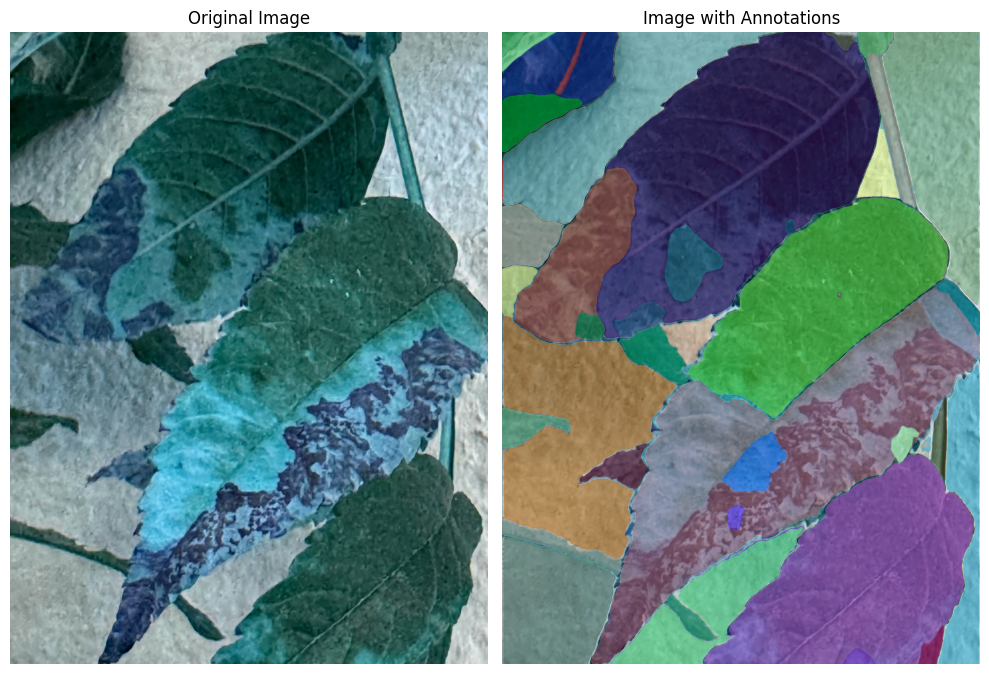

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Left: image only
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Right: image + annotations
axes[1].imshow(image)
plt.sca(axes[1])  # set current axis
show_anns(masks)
axes[1].axis('off')
axes[1].set_title("Image with Annotations")

plt.tight_layout()
plt.show()

## We can do better
The masks generated by SAM automatically are impressive, but we care mostly about the diseased areas.

We will create a color mask that highlights possibly diseased areas and choose the SAM masks that best align with it.



In [30]:
disease_mask = color_mask(image_name)
filtered_masks = []
for res in masks:
    mask = res["segmentation"].astype("uint8")
    inter = np.count_nonzero(mask & (disease_mask > 0))
    if inter > 0.2 * np.count_nonzero(mask):
        filtered_masks.append(res)               # keep only good masks

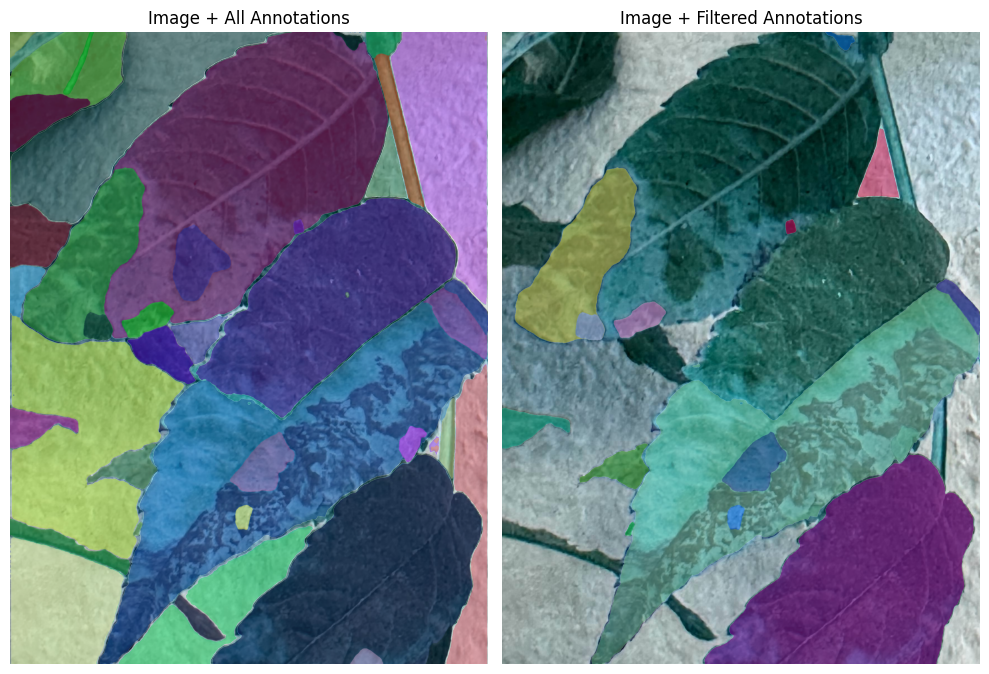

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Left: image + all annotations
axes[0].imshow(image)
plt.sca(axes[0])  # set current axis
show_anns(masks)
axes[0].axis('off')
axes[0].set_title("Image + All Annotations")

# Right: image + filtered annotations
axes[1].imshow(image)
plt.sca(axes[1])  # set current axis
show_anns(filtered_masks)
axes[1].axis('off')
axes[1].set_title("Image + Filtered Annotations")

plt.tight_layout()
plt.show()

## Crop segments for analysis
SAM returns the bounding box coordinates for each mask. If we were to crop each segment directly, some might be too small for later analysis. Hence, we'll ensure the crops are large enough and not overlapping.

In [32]:
crops = crop_segments(image, filtered_masks)

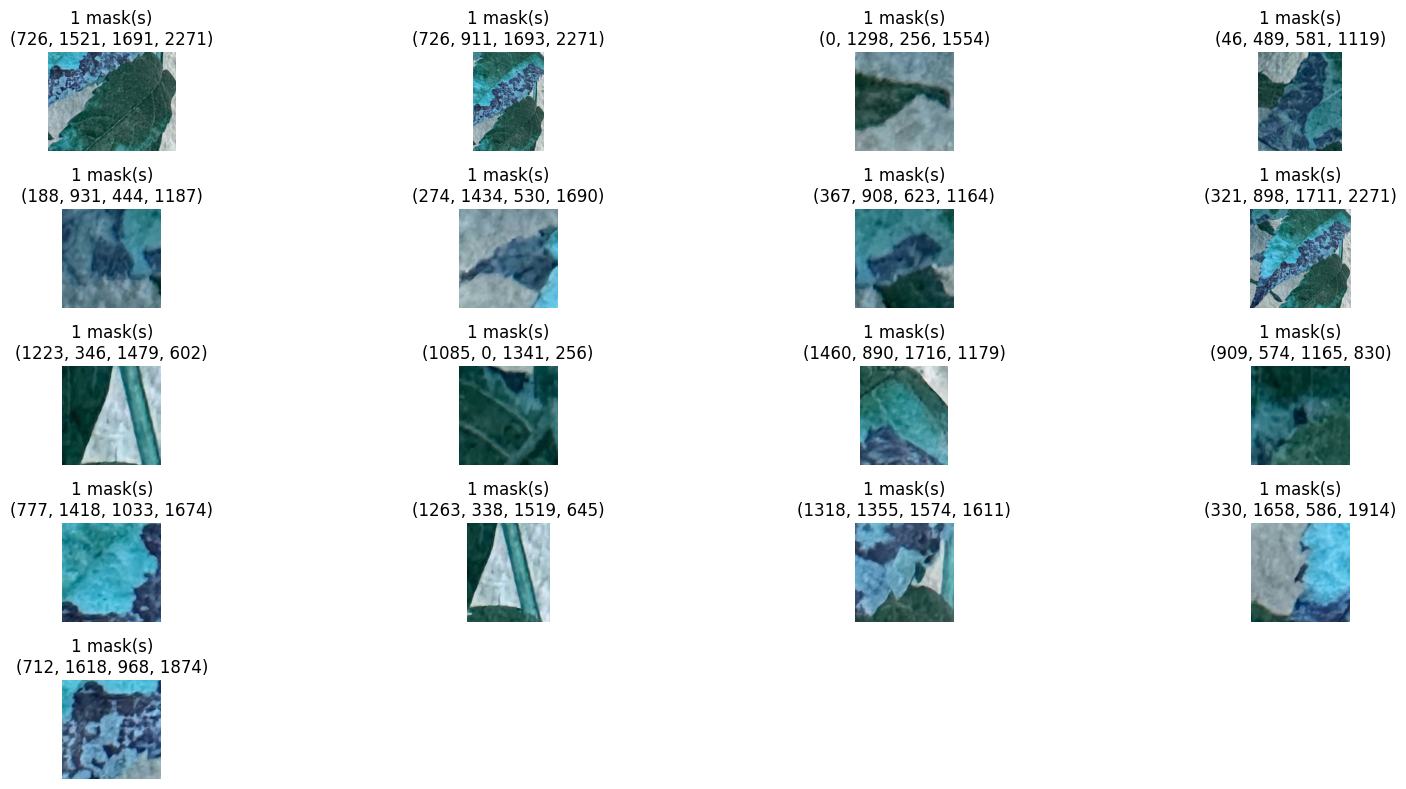

In [33]:
def show_crops(crops, max_cols=4, figsize=(16, 8)):
    """
    crops: output of `crop_segments`, list of dicts with keys 'crop', 'anns', 'bounds'
    max_cols: max number of columns in the plot grid
    """
    num = len(crops)
    cols = min(num, max_cols)
    rows = (num + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, crop_data in enumerate(crops):
        crop = crop_data['crop']
        anns = crop_data['anns']
        bounds = crop_data['bounds']

        plt.subplot(rows, cols, i+1)
        plt.imshow(crop)
        plt.title(f"{len(anns)} mask(s)\n{bounds}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_crops(crops)


## Load and setup CLIP

# Full pipeline

# More examples

# Resources